In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

import scipy.stats as stats
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

import datetime as dt
from datetime import timezone, timedelta

In [2]:
timezone_offset = -5.0  # Eastern Standard Time (UTC−08:00)
tzinfo = timezone(timedelta(hours=timezone_offset))
current_dateTime = datetime.now(tzinfo)

In [3]:
begin_date = '2024-08-12T00:00:00.000-05:00'
#end_date = '2024-08-14T11:00:00.000-05:00'
end_date = current_dateTime.strftime('%Y-%m-%dT%H:%M:%S.%f%z')


In [4]:
print(end_date)

2024-10-17T14:20:48.453866-0500


In [5]:
print(current_dateTime.strftime('%Y-%m-%dT%H:%M:%S.%f%z'))

2024-10-17T14:20:48.453866-0500


In [6]:
#print(end_date)

In [7]:
#Read in raw stream gage data
gage = pd.read_csv('https://nwis.waterservices.usgs.gov/nwis/iv/?sites=01473730&parameterCd=00065&startDT='+begin_date+'&endDT='+end_date+'&siteStatus=all&format=rdb', sep='\t', skiprows=26)
gage = gage.iloc[1: , :]

In [8]:
gage['328674_00065'] = gage['328674_00065'].astype(float)
gage = gage[['datetime','328674_00065']]
gage = gage.set_index('datetime')
gage['item_id'] = 'gage'
gage  = gage.rename(columns={"328674_00065": "series"})
gage.head()

,series,item_id
datetime,,
2024-08-12 01:00,8.25,gage
2024-08-12 01:15,8.24,gage
2024-08-12 01:30,8.23,gage
2024-08-12 01:45,8.22,gage
2024-08-12 02:00,8.20,gage


In [9]:
#Read in raw flow data
flow = pd.read_csv('https://waterservices.usgs.gov/nwis/iv/?sites=01473730&parameterCd=00060&startDT='+begin_date+'&endDT='+end_date+'&siteStatus=all&format=rdb', sep='\t', skiprows=26)
flow = flow.iloc[1: , :]

In [10]:
flow['328771_00060'] = flow['328771_00060'].astype(float)
flow = flow[['datetime','328771_00060']]# Merge datasets together on datetime index and check if everything is good
flow = flow.set_index('datetime')
flow['item_id'] = 'flow'

            
#df=pd.merge(gage, flow, how='inner', left_index=True, right_index=True)
#df.head()
flow  = flow.rename(columns={"328771_00060": "series"})

flow.head()

,series,item_id
datetime,,
2024-08-12 01:00,2980.0,flow
2024-08-12 01:15,2970.0,flow
2024-08-12 01:30,2950.0,flow
2024-08-12 01:45,2940.0,flow
2024-08-12 02:00,2910.0,flow


In [11]:
merge = pd.concat([gage, flow])

In [12]:
merge

,series,item_id
datetime,,
2024-08-12 01:00,8.25,gage
2024-08-12 01:15,8.24,gage
2024-08-12 01:30,8.23,gage
2024-08-12 01:45,8.22,gage
2024-08-12 02:00,8.20,gage
...,...,...
2024-10-17 13:30,644.00,flow
2024-10-17 13:45,675.00,flow
2024-10-17 14:00,675.00,flow


In [13]:
merge.reset_index(inplace=True)

merge

,datetime,series,item_id
0,2024-08-12 01:00,8.25,gage
1,2024-08-12 01:15,8.24,gage
2,2024-08-12 01:30,8.23,gage
3,2024-08-12 01:45,8.22,gage
4,2024-08-12 02:00,8.20,gage
...,...,...,...
13011,2024-10-17 13:30,644.00,flow
13012,2024-10-17 13:45,675.00,flow
13013,2024-10-17 14:00,675.00,flow
13014,2024-10-17 14:15,675.00,flow


In [14]:
test_data = TimeSeriesDataFrame.from_data_frame(merge, id_column="item_id", timestamp_column='datetime') #, timestamp_column=merge.index
test_data = test_data.convert_frequency(freq='H', agg_numeric="max")
test_data.head()

/Users/tott/opt/anaconda3/envs/py310/lib/python3.10/site-packages/autogluon/timeseries/dataset/ts_dataframe.py:942: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)


series
item_id timestamp                  
gage    2024-08-12 01:00:00    8.25
        2024-08-12 02:00:00    8.20
        2024-08-12 03:00:00    8.18
        2024-08-12 04:00:00    8.14
        2024-08-12 05:00:00    8.11

In [15]:
predictor = TimeSeriesPredictor.load('schuylkill_gage_autogluon')

In [16]:
predictions = predictor.predict(test_data)

data contains missing values represented by NaN. They have been filled by carrying forward the last valid observation.


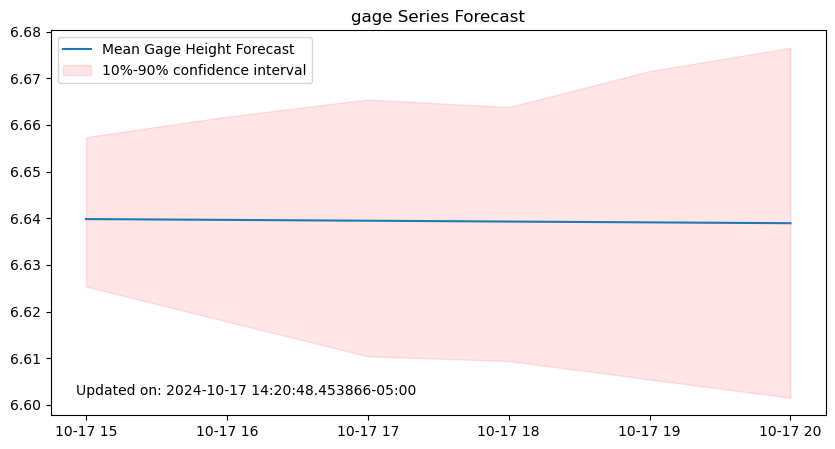

In [23]:
# TimeSeriesDataFrame can also be loaded directly from a file
#test_data = TimeSeriesDataFrame.from_path("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/test.csv")

#test_data = predictions

item_id = 'gage'

plt.figure(figsize=(10, 5))
plt.title(item_id+' Series Forecast')

y_pred = predictions.loc[item_id]

plt.plot(y_pred["mean"], label="Mean Gage Height Forecast")


plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.figtext(0.15, 0.15, 'Updated on: '+str(current_dateTime), ha='left', fontsize=10)
plt.legend(loc = 'upper left');
plt.savefig('forecast.png')

In [24]:
y_pred[['mean', '0.1', '0.9']]

,mean,0.1,0.9
timestamp,,,
2024-10-17 15:00:00,6.639820,6.625352,6.657385
2024-10-17 16:00:00,6.639642,6.617865,6.661772
2024-10-17 17:00:00,6.639464,6.610397,6.665447
2024-10-17 18:00:00,6.639287,6.609387,6.663827
2024-10-17 19:00:00,6.639109,6.605447,6.671534
2024-10-17 20:00:00,6.638931,6.601512,6.676536


In [18]:
print(current_dateTime)

2024-10-17 14:20:48.453866-05:00
